In [1]:


import gym
import highway_env

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import trange
import base64
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
# IO
from pathlib import Path

<h1> Data Collection</h1>

In [2]:
def get_dataset(env, size=1000, action_repeat=2):
    data, done = [], True
    for _ in trange(size, desc="Collecting interaction data"):
        action = env.action_space.sample()
        for _ in range(action_repeat):
            previous_obs = env.reset() if done else obs
            obs, reward, done, info = env.step(action)
            data.append(DataSet(torch.Tensor(previous_obs["observation"]),
                                   torch.Tensor(action),
                                   torch.Tensor(obs["observation"])))
    return data

<h1> Dynamic Model Neural Network </h1>

In [3]:
class DQN(nn.Module):
    xstate = 0
    ystate = 1

    def __init__(self, state, action, policy_frequency):
        super().__init__()
        self.state, self.action, self.policy_frequency = state, action, policy_frequency
        self.A1 = nn.Linear(state + action, 64)
        self.A2 = nn.Linear(64, state * state)
        self.B1 = nn.Linear(state + action, 64)
        self.B2 = nn.Linear(64, state * action)

    def forward(self, x, u):
        xu = torch.cat((x, u), -1)
        xu[:, self.xstate:self.ystate+1] = 0  # Remove dependency in (x,y)
        A = self.A2(F.relu(self.A1(xu)))
        A = torch.reshape(A, (x.shape[0], self.state, self.state))
        B = self.B2(F.relu(self.B1(xu)))
        B = torch.reshape(B, (x.shape[0], self.state, self.action))
        dx = A @ x.unsqueeze(-1) + B @ u.unsqueeze(-1)
        return x + dx.squeeze()*self.policy_frequency


In [4]:
def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
    states, actions, next_states = data_t
    predictions = model(states, actions)
    return loss_func(predictions, next_states)
def get_batch(batch):
    return DataSet(*map(torch.stack, zip(*batch)))

<h1> Training the Dataset</h1>

In [5]:
def train(model, train_data, validation_data, epochs=1500):
    train_data_batch = get_batch(train_data)
    validation_data_batch = get_batch(validation_data)
    losses = np.full((epochs, 2), np.nan)
    for epoch in trange(epochs, desc="Train dynamics"):
        loss = compute_loss(model, train_data_batch)
        validation_loss = compute_loss(model, validation_data_batch)
        losses[epoch] = [loss.detach().numpy(), validation_loss.detach().numpy()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    plt.plot(losses)
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["training", "validation"])
    plt.show()

In [6]:
def get_reward(states, goal):
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(env.unwrapped.config["reward_weights"])
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=-1), 0.5)
    return rewards



<h1> Cross entropy planner</h1>

In [7]:
def predict_trajectory(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

def cross_entropy(state, goal, action_size, horizon=5, population=100, selection=10, iterations=5):
    state = state.expand(population, -1)
    action_mean = torch.zeros(horizon, 1, action_size)
    action_std = torch.ones(horizon, 1, action_size)
    for _ in range(iterations):
        actions = action_mean + action_std * torch.randn(horizon, population, action_size)
        actions = torch.clamp(actions, min=env.action_space.low.min(), max=env.action_space.high.max())
        states = predict_trajectory(state, actions, dynamics, action_repeat=5)
        rewards = get_reward(states, goal).sum(dim=0)
        _, best = rewards.topk(selection, largest=True, sorted=False)
        best_actions = actions[:, best, :]
        action_mean, action_std = best_actions.mean(dim=1, keepdim=True), best_actions.std(dim=1, unbiased=False, keepdim=True)
    return action_mean[0].squeeze(dim=0)

Train dynamics:   0%|          | 0/1500 [00:00<?, ?it/s]

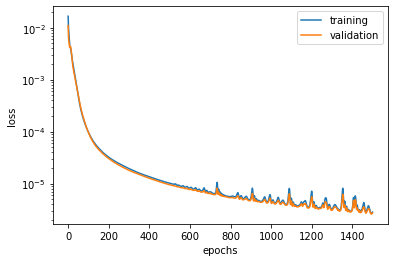

In [8]:
train_ratio = 0.7
DataSet = namedtuple('DataSet', ['state', 'action', 'next_state'])
env = gym.make("parking-v0")
data = get_dataset(env)
dynamics = DQN(env.observation_space.spaces["observation"].shape[0],env.action_space.shape[0],1/env.unwrapped.config["policy_frequency"])
optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.01)
train_data, validation_data = data[:int(train_ratio * len(data))], \
                              data[int(train_ratio * len(data)):]
train(dynamics, data, validation_data)

<h1> Visualize Episodes</h1>

In [9]:
obs = env.reset()
for step in range(3 * env.config["duration"]):
    action = cross_entropy(torch.Tensor(obs["observation"]),
                         torch.Tensor(obs["desired_goal"]),
                         env.action_space.shape[0])
    env.render()
    obs, reward, done, info = env.step(action.numpy())
    if done:
        obs = env.reset()
env.close()
